https://pymdp-rtd.readthedocs.io/en/latest/notebooks/active_inference_from_scratch.html

Building the generative model: $\mathbf{A}$, $\mathbf{B}$, $\mathbf{C}$, and $\mathbf{D}$

$$ P(x) = \begin{bmatrix} P(x = 0) \ P(x = 1)\ \vdots \ P(x = K) \end{bmatrix} $$

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

In [36]:
from pymdp import utils

In [37]:
my_categorical = np.random.rand(3)
# my_categorical = np.array([0.5, 0.3, 0.8]) # could also just write in your own numbers
my_categorical = utils.norm_dist(my_categorical) # normalizes the distribution so it integrates to 1.0

print(my_categorical.reshape(-1,1)) # we reshape it to display it like a column vector
print(f'Integral of the distribution: {round(my_categorical.sum(), 2)}')

[[0.43179177]
 [0.02303968]
 [0.54516854]]
Integral of the distribution: 1.0


In [38]:
sampled_outcome = utils.sample(my_categorical)
print(f'Sampled outcome: {sampled_outcome}')

Sampled outcome: 2


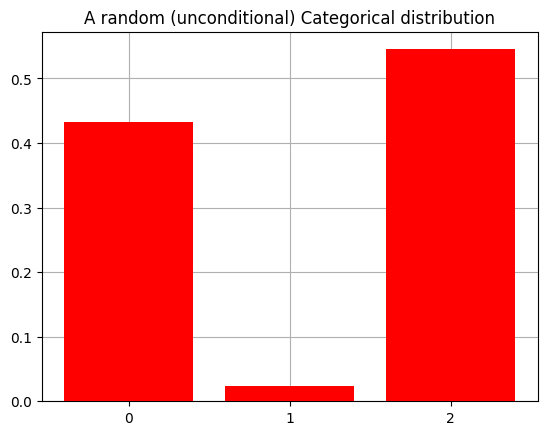

In [39]:
plot_beliefs(my_categorical, title_str = "A random (unconditional) Categorical distribution")

In [40]:
# initialize it with random numbers
p_x_given_y = np.random.rand(3, 4)
print(p_x_given_y.round(3))

[[0.154 0.382 0.353 0.844]
 [0.47  0.081 0.82  0.739]
 [0.677 0.372 0.695 0.035]]


In [41]:
# normalize it
p_x_given_y = utils.norm_dist(p_x_given_y)
print(p_x_given_y.round(3))

[[0.118 0.457 0.189 0.522]
 [0.361 0.097 0.439 0.457]
 [0.52  0.446 0.372 0.022]]


In [42]:
print(p_x_given_y[:,0].reshape(-1,1))
print(f'Integral of P(X|Y=0): {p_x_given_y[:,0].sum()}')

[[0.1181322 ]
 [0.36144745]
 [0.52042035]]
Integral of P(X|Y=0): 1.0


In [43]:
""" Create a P(Y) and P(X|Y) using the same numbers from the slides """

p_y = np.array([0.75, 0.25]) # this is already normalized - you don't need to `utils.norm_dist()` it!

# the columns here are already normalized - you don't need to `utils.norm_dist()` it!
p_x_given_y = np.array([[0.6, 0.5],
                        [0.15, 0.41], 
                        [0.25, 0.09]])

print(p_y.round(3).reshape(-1,1))
print(p_x_given_y.round(3))

[[0.75]
 [0.25]]
[[0.6  0.5 ]
 [0.15 0.41]
 [0.25 0.09]]


In [44]:
""" Calculate the expectation using numpy's dot product functionality """

# first version of the dot product (using the method of a numpy array)
E_x_wrt_y = p_x_given_y.dot(p_y)

# second version of the dot product (using the function np.dot with two arguments)
# E_x_wrt_y = np.dot(p_x_given_y, p_y)

In [45]:
print(E_x_wrt_y)
print(f'Integral: {E_x_wrt_y.sum().round(3)}')

[0.575 0.215 0.21 ]
Integral: 1.0


A simple environment: Grid-world

In [46]:
import itertools

""" Create  the grid locations in the form of a list of (Y, X) tuples -- HINT: use itertools """
grid_locations = list(itertools.product(range(3), repeat = 2))
print(grid_locations)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


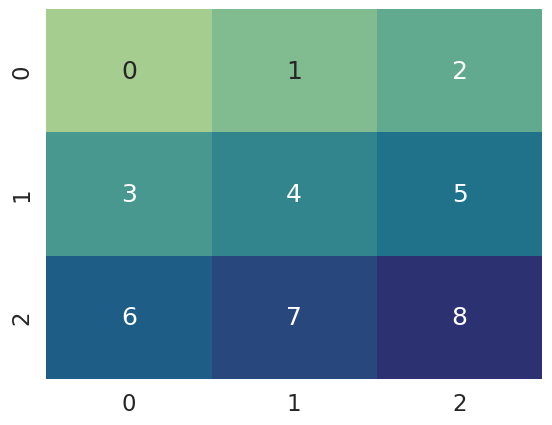

In [47]:
plot_grid(grid_locations)

The generative model’s “prior beliefs” about how hidden states relate to observations

In [48]:
""" Create variables for the storing the dimensionalities of the hidden states and the observations """

n_states = len(grid_locations)
n_observations = len(grid_locations)

print(f'Dimensionality of hidden states: {n_states}')
print(f'Dimensionality of observations: {n_observations}')

Dimensionality of hidden states: 9
Dimensionality of observations: 9


In [49]:
""" Create the A matrix  """

A = np.zeros( (n_states, n_observations) )

In [50]:
""" Create an umambiguous or 'noise-less' mapping between hidden states and observations """

np.fill_diagonal(A, 1.0)

# alternative:
# A = np.eye(n_observations, n_states)

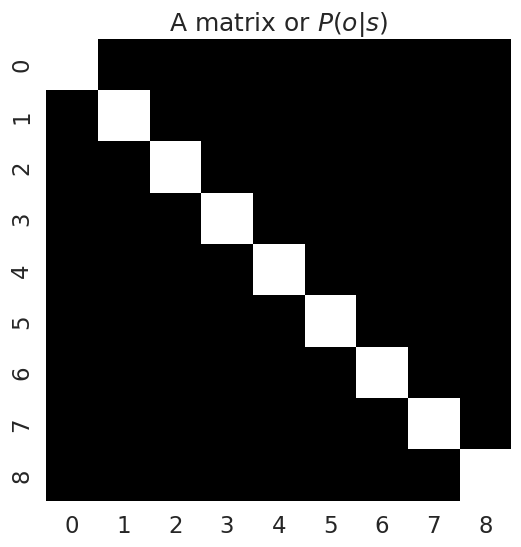

In [51]:
plot_likelihood(A, title_str = "A matrix or $P(o|s)$")

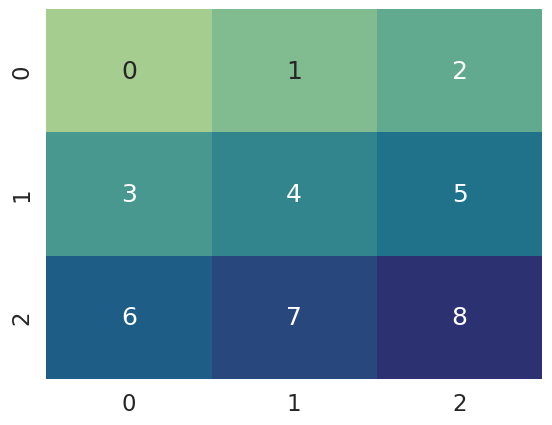

In [52]:
""" Remind yourself of the mapping between linear indices (0 through 8) and grid locations (Y, X) """
plot_grid(grid_locations)

In [53]:
A_noisy = A.copy()

# this line says: the probability of seeing yourself in location 0, given you're in location 0, is 1/3, AKA P(o == 0 | s == 0) = 0.3333....
A_noisy[0,0] = 1 / 3.0 # corresponds to location (0,0)

# this line says: the probability of seeing yourself in location 1, given you're in location 0, is 1/3, AKA P(o == 1 | s == 0) = 0.3333....
A_noisy[1,0] = 1 / 3.0 # corresponds to one step to the right from (0, 1)

# this line says: the probability of seeing yourself in location 3, given you're in location 0, is 1/3, AKA P(o == 3 | s == 0) = 0.3333....
A_noisy[3,0] = 1 / 3.0 # corresponds to one step down from (1, 0)

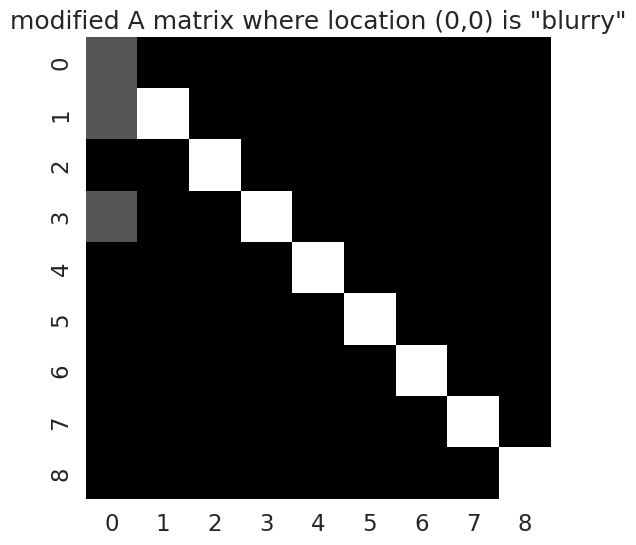

In [54]:
plot_likelihood(A_noisy, title_str = 'modified A matrix where location (0,0) is "blurry"')

In [55]:
""" Let's make ake one grid location "ambiguous" in the sense that it could be easily confused with neighbouring locations """
my_A_noisy = A_noisy.copy()

# locations 3 and 7 are the nearest neighbours to location 6
my_A_noisy[3,6] = 1.0 / 3.0
my_A_noisy[6,6] = 1.0 / 3.0
my_A_noisy[7,6] = 1.0 / 3.0

# Alternatively: you could have the probability spread among locations 3, 4, 6, and 7. This is basically saying, that whole lower-left corner of grid-world is blurry, if you're in location 6
# Remember to make sure the A matrix is column normalized. So if you do it this way, with the probabilities spread among 4 perceived locations, then you'll have to make sure the probabilities sum to 1.0
# my_A_noisy[3,6] = 1.0 / 4.0
# my_A_noisy[4,6] = 1.0 / 4.0
# my_A_noisy[6,6] = 1.0 / 4.0
# my_A_noisy[7,6] = 1.0 / 4.0

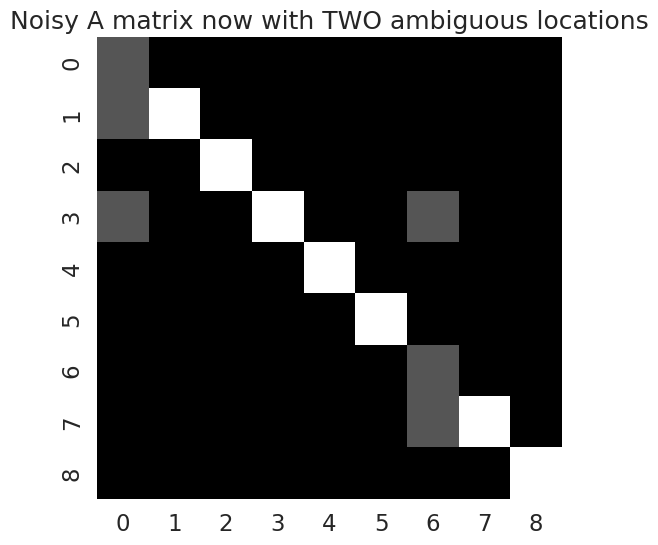

In [56]:
plot_likelihood(my_A_noisy, title_str = "Noisy A matrix now with TWO ambiguous locations")

In [57]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

B = create_B_matrix()

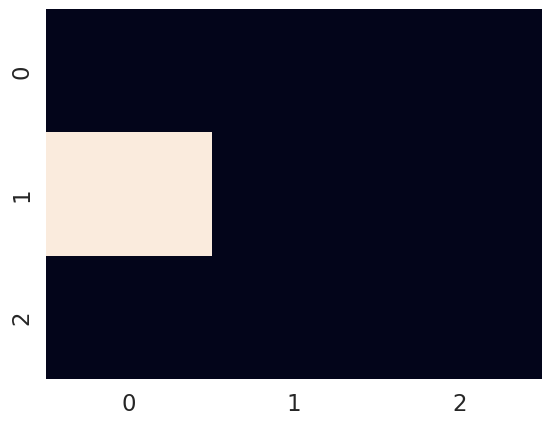

In [58]:
""" Define a starting location""" 
starting_location = (1,0)

"""get the linear index of the state"""
state_index = grid_locations.index(starting_location)

"""  and create a state vector out of it """
starting_state = utils.onehot(state_index, n_states)

plot_point_on_grid(starting_state, grid_locations)

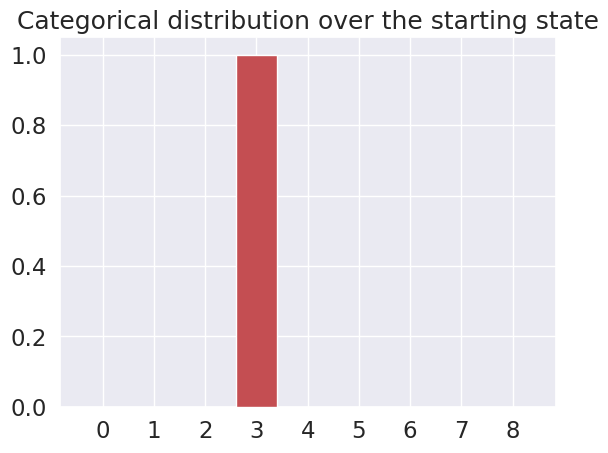

In [59]:
plot_beliefs(starting_state, "Categorical distribution over the starting state")

Now let’s imagine we’re moving “RIGHT” - write the conditional expectation, that will create the state vector corresponding to the new state after taking a step to the right.

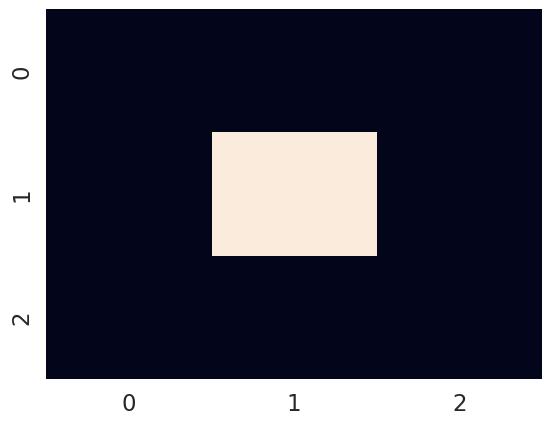

In [60]:
""" Redefine the action here, just for reference """
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

""" Generate the next state vector, given the starting state and the B matrix"""
right_action_idx = actions.index("RIGHT") 
next_state = B[:,:, right_action_idx].dot(starting_state) # input the indices to the B matrix

""" Plot the next state, after taking the action """
plot_point_on_grid(next_state, grid_locations)

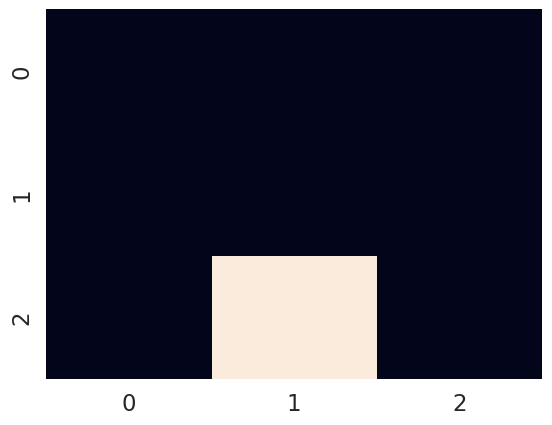

In [61]:
""" Generate the next state vector, given the previous state and the B matrix"""
prev_state = next_state.copy()
down_action_index = actions.index("DOWN")
next_state = B[:,:,down_action_index].dot(prev_state)

"""  Plot the new state vector, after making the movement """
plot_point_on_grid(next_state, grid_locations)

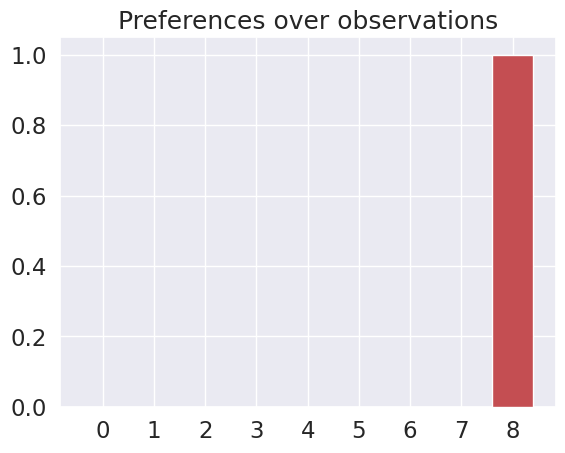

In [62]:
""" Create an empty vector to store the preferences over observations """
C = np.zeros(n_observations)

""" Choose an observation index to be the 'desired' rewarding index, and fill out the C vector accordingly """
desired_location = (2,2) # choose a desired location
desired_location_index = grid_locations.index(desired_location) # get the linear index of the grid location, in terms of 0 through 8

C[desired_location_index] = 1.0 # set the preference for that location to be 100%, i.e. 1.0

"""  Let's look at the prior preference distribution """
plot_beliefs(C, title_str = "Preferences over observations")

3. The prior over hidden states: the $\mathbf{D}$ vector or $P(s)$

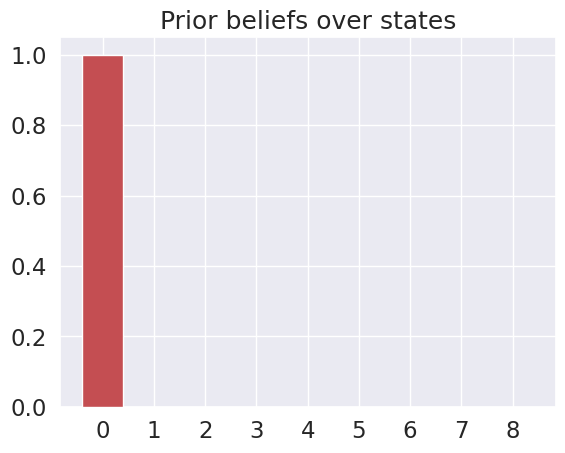

In [63]:
""" Create a D vector, basically a belief that the agent has about its own starting location """

# create a one-hot / certain belief about initial state
D = utils.onehot(0, n_states)

# demonstrate hwo belief about initial state can also be uncertain / spread among different possible initial states
# alternative, where you have a degenerate/noisy prior belief
# D = utils.norm_dist(np.ones(n_states))

""" Let's look at the prior over hidden states """
plot_beliefs(D, title_str = "Prior beliefs over states")

Hidden state inference

$$ \begin{align} q(s_t) = \sigma\left(\ln \mathbf{A}[o,:] + \ln\mathbf{B}[:,:,u] \cdot q(s_{t-1})\right) \end{align} $$

In [64]:
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable

In [65]:
""" Create an infer states function that implements the math we just discussed"""

def infer_states(observation_index, A, prior):

  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs

In [66]:
qs_past = utils.onehot(4, n_states) # agent believes they were at location 4 -- i.e. (1,1) one timestep ago

last_action = "UP" # the agent knew it moved "UP" one timestep ago
action_id = actions.index(last_action) # get the action index for moving "UP"

$$ \begin{align} P(s_t) = \mathbf{E}{q(s{t-1})}\left[P(s_t | s_{t-1}, u_{t-1})\right] \end{align} $$